# Model Baseline 

For this baseline model, we'll use all features without prior selection.
Logistic regression is often a good model to use for a classification baseline
(reasonably fast and easy to interpret).
We'll fit a different model for each of the targets `h1n1_vaccine` and `seasonal_vaccine`
as data exploration showed significant differences in how the features related to each,
in particular for the respondents' perceived risk and vaccine effectiveness for each 
disease (e.g. `opinion_h1n1_sick_from_vacc`)


In [78]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Figure prettifying:

In [2]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150
})
sns.set()

## Data pre-processing

In [3]:
DATA_PATH = '../../data/raw'
X_train = pd.read_csv(
    os.path.join(DATA_PATH, 'training_set_features.csv')
).drop('respondent_id',axis =1)

X_test = pd.read_csv(
    os.path.join(DATA_PATH, 'test_set_features.csv')
).drop('respondent_id',axis =1)

y_train = pd.read_csv(
    os.path.join(DATA_PATH, 'training_set_labels.csv')
).drop('respondent_id',axis =1)

sub = pd.read_csv(os.path.join(DATA_PATH, 'submission_format.csv'))

Missing value imputation

## Models

Common utilities for preprocessing in the pipelines. We can create an special `missing` value to impute 
categorical features. For numerical features, we'll use K-nearest neighbors imputation, wich in general
produces better results than imputation along the mean

In [79]:
num_features = X_train.columns[X_train.dtypes != "object"].values
cat_features = X_train.columns[X_train.dtypes == "object"].values

num_transformer = Pipeline([
    ('scale', StandardScaler()),
    ('impute', KNNImputer(n_neighbors = 10))
])

cat_transformer = Pipeline([
    ('impute', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('encode', OneHotEncoder(drop = 'first'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])


### Logistic Regression

Logistic regression usually makes a decent baseline for classification problems. As we need to predict two different 
values, we will use a `MultiOutputClassifier`

In [91]:
X_train.shape

(26707, 35)

The choice of $L1$ regularization was a bit arbitrary, but motivated by the high number of features 
(relative to the number of training examples) after one-hot encoding. The `saga` solver is used because
there a a significant number of training samples (though not so high that I am not sure whether LFBGS would be faster)

In [90]:
def get_model(C = 1):
    model = Pipeline([
        ('pre', preprocessor),
        ('model', MultiOutputClassifier(LogisticRegression(
            penalty = 'l1', 
            C = C,
            solver = 'saga'
        )))
    ])
    return model

Logistic regression only has one major hyperparameter, the regularization $C$. Generate an array of choices of $C$
to evaluate performance

In [60]:
Cs = np.logspace(-2, 1, num = 10, base = 10)
means = []
stds = []
best_auc = 0

for C in Cs:
    cv = cross_validate(
        estimator = get_model(C),
        X = X_train,
        y = y_train,
        cv = 5,
        n_jobs = -1,
        scoring = 'roc_auc',
    )
    means.append(np.mean(cv['test_score']))
    stds.append(np.std(cv['test_score']))
    if means[-1] > best_auc:
        best_C = C
        best_auc = means[-1]
        print('New best AUC: ' + best_auc + ' for C=' + best_C)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   58.6s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   58.7s remaining:   39.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.8359570068602908
0.00454557237059546


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.1min remaining:   43.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.8384926555108251
0.004309168953361544


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.1min remaining:   42.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.8415477130286263
0.0041589998513324195


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   59.0s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.8426449163882058
0.004222060302828883


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   58.2s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   58.5s remaining:   39.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.6s finished


0.8430384315713294
0.004216902093193638


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.1min remaining:   45.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


0.8430694812799034
0.004218082544784668


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


0.843010269439359
0.004221532261750377


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.2min remaining:   49.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


0.8429331781076586
0.0042248864356163865


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.2min remaining:   48.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.842881962434461
0.004230080428360176


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.4min remaining:   54.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


0.842860234620083
0.004226259268194887


In [92]:
print(means)

[0.8359570068602908, 0.8384926555108251, 0.8415477130286263, 0.8426449163882058, 0.8430384315713294, 0.8430694812799034, 0.843010269439359, 0.8429331781076586, 0.842881962434461, 0.842860234620083]


In [66]:
print(best_auc)

0.8430694812799034


In [68]:
print(best_C)

0.46415888336127775


In [98]:
from typing import List

In [104]:
from sklearn import pipeline, compose, preprocessing, impute

In [105]:
def _get_preprocessor(num_features: List[str], cat_features: List[str]) -> Pipeline:

    num_transformer = pipeline.Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('impute', impute.KNNImputer(n_neighbors = 10))
    ])

    cat_transformer = pipeline.Pipeline([
        ('impute', impute.SimpleImputer(
            strategy = 'constant', 
            fill_value = 'missing'
        )),
        ('encode', preprocessing.OneHotEncoder(drop = 'first'))
    ])

    preprocessor = compose.ColumnTransformer([
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

In [107]:
trest = _get_preprocessor(num_features, cat_features)

Plot these results for reporting

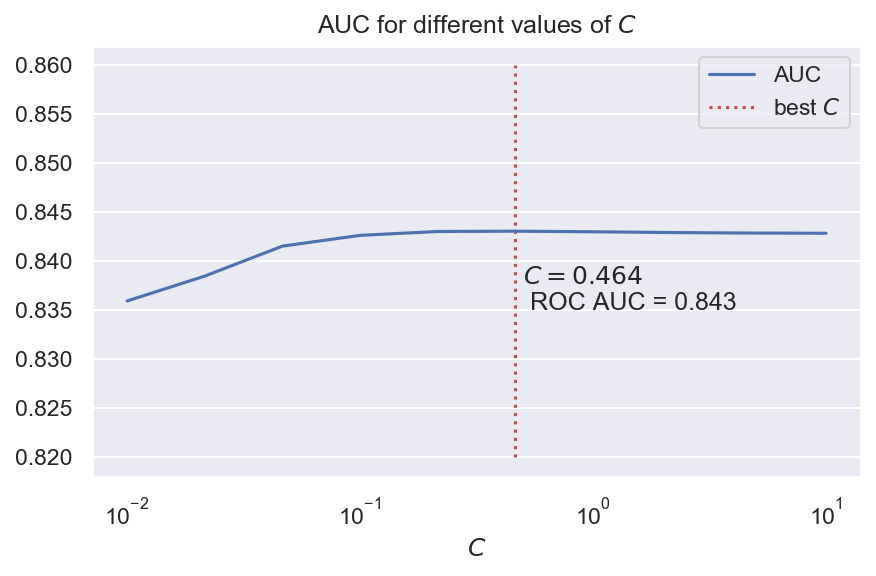

In [89]:
fig, ax = plt.subplots()
ax.plot(Cs, means)
ax.vlines(best_C, ymin = 0.82, ymax = 0.86,  colors = 'r', linestyle = 'dotted')
ax.annotate("$C = 0.464$ \n ROC AUC = 0.843", xy = (0.5, 0.835))
ax.set_xscale('log')
ax.set_xlabel('$C$')
ax.grid(axis = 'x')
ax.legend(['AUC', 'best $C$'])
ax.set_title('AUC for different values of $C$')
fig.savefig('../../paper/figures/reg_performance.png')

Our best AUC score beats the benchmark by a good margin, so we will make a submission using
the model with $C = 1$ (AUC seems constant for $C > 0.5$)

## Building a submission

Refit the logistic regression model with $C = 1$

In [72]:
model = get_model(1)
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)

Note that this returns two arrays, each with the predicted probabilities for *each class* for *each* of the two classifiers,
we need to be careful in selecting the correct predictions!

In [77]:
sub['h1n1_vaccine'] = preds[0][:,1]
sub['seasonal_vaccine'] = preds[1][:,1]
sub.to_csv('../../output/baseline_pred.csv', index = False)

### Results

0.8342 AUC on leaderboard, for a ranking of 181/948